# Bike Rental Prediction


In this project, we will try to predict the total number of bikes people rented in a given hour. The data we will work with can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.


Here are the descriptions for the relevant columns:

* **instant**: record index
* **dteday** : date
* **season** : season (1:winter, 2:spring, 3:summer, 4:fall)
* **yr** : year (0: 2011, 1:2012)
* **mnth** : month ( 1 to 12)
* **hr** : hour (0 to 23)
* **holiday** : weather day is holiday or not (extracted from Department of Human Resources)
* **weekday** : day of the week
* **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0
* **weathersit** :
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **temp** : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* **atemp**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* **hum**: Normalized humidity. The values are divided to 100 (max)
* **windspeed**: Normalized wind speed. The values are divided to 67 (max)
* **casual**: count of casual users
* **registered**: count of registered users
* **cnt**: count of total rental bikes including both casual and registered

## Initial data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
import seaborn as sns

bike_rentals = pd.read_csv('hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

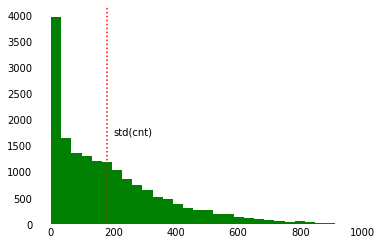

In [3]:
cnt_std = bike_rentals['cnt'].std()
plt.hist(bike_rentals['cnt'], color= 'green', bins=30)
plt.box(False)
plt.tick_params(axis='both', which='both',length=0)
plt.axvline(cnt_std, ls='dotted', c='r')
plt.text(x=cnt_std*1.1, y=1700, s='std(cnt)', size=10)
plt.show()

In [4]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

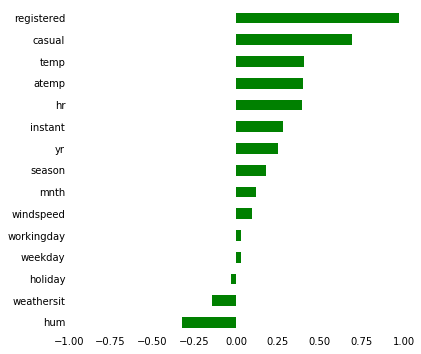

In [5]:
bike_rentals.corr()["cnt"].sort_values()[:-1].plot.barh(color='green', figsize=(6,6))
_ = plt.xlim(-1,1)
_ = plt.box(False)
_ = plt.tick_params(axis='both', which='both',length=0)

### Feature correlation with hourly rentals

Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [6]:
def assign_label(hour_value):
    if hour_value >= 6 and hour_value < 12:
        return 1
    if hour_value >= 12 and hour_value < 18:
        return 2
    if hour_value >= 18 and hour_value < 24:
        return 3
    if hour_value >= 0 and hour_value < 6:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [7]:
print("Group hours with labels")
bike_rentals[['hr', 'time_label']].sample(10)

Group hours with labels


,hr,time_label
16741,8,1
1412,3,4
11013,1,4
2673,7,1
12107,16,2
7268,11,1
10023,16,2
1395,10,1
7458,9,1
10863,19,3


## Machine Learning

### Evaluation criteria

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well. In simple words: it measures the average squared difference between the estimated values and the actual values. The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.

### Train and test data

We will 80% of the rows in bike_rentals to be part of the training set and the remaining in the test set.

In [8]:
train = bike_rentals.sample(frac= 0.8, random_state=5)
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
4707,4708,2011-07-20,3,0,7,1,0,3,1,1,0.70,0.6667,0.84,0.0000,4,7,11,4
13755,13756,2012-08-01,3,1,8,8,0,3,1,2,0.66,0.6061,0.78,0.1940,32,649,681,1
10794,10795,2012-03-30,2,1,3,21,0,5,1,1,0.38,0.3939,0.66,0.1343,30,190,220,3
7665,7666,2011-11-21,4,0,11,0,0,1,1,2,0.46,0.4545,0.94,0.0000,4,13,17,4
9751,9752,2012-02-16,1,1,2,6,0,4,1,2,0.30,0.3182,0.70,0.0896,4,83,87,1


In [9]:
filter_series = bike_rentals.index.isin(train.index)
test = bike_rentals.loc[~filter_series]
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
10,11,2011-01-01,1,0,1,10,0,6,0,1,0.38,0.3939,0.76,0.2537,12,24,36,1
16,17,2011-01-01,1,0,1,16,0,6,0,2,0.42,0.4242,0.82,0.2985,41,52,93,2
18,19,2011-01-01,1,0,1,18,0,6,0,3,0.42,0.4242,0.88,0.2537,9,26,35,3
22,23,2011-01-01,1,0,1,22,0,6,0,2,0.40,0.4091,0.94,0.2239,11,17,28,3


In [10]:
print('{} rows for train and {} rows for test sets'.format(train.shape[0], test.shape[0]))

13903 rows for train and 3476 rows for test sets


### Filtering only useful features

We'll need to ignore the casual and registered columns because cnt is derived from them. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

In [11]:
features = train.columns.drop(['casual', 'registered', 'cnt', 'dteday'])
features

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [12]:
# check correlations
correlations = bike_rentals.corr()['cnt'][features].sort_values(ascending=False)
correlations

temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

temp and atemp have almost the same information but I decided to drop 'temp'.  The reason is that apparent temperature ('atemp') is an index. I think this index is better because combines temperature with wind and/or humidity information ([more info here](https://meteor.geol.iastate.edu/~ckarsten/bufkit/apparent_temperature.html)).

In [13]:
features = features.drop('temp')

We can simplify the features to a smaller list. We will choose a threshold of 0.25 to the correlations (positive and  negative). If the correlation is lower than the threshold, then this feature is removed. We'll keep the feature otherwise. The following features have the highest correlations:

In [14]:
sel_pos = correlations > 0.25 
sel_neg = correlations <-0.25 
sel_strict = sel_neg | sel_pos

correlations_strict = correlations.loc[sel_strict]
correlations_strict

temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

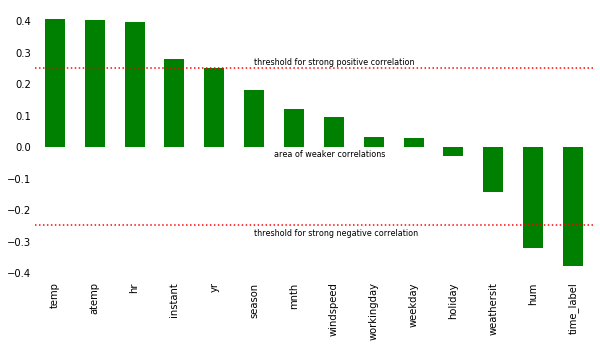

In [15]:
threshold = 0.25
correlations.plot.bar(color='green', figsize=(10,5))
_ = plt.box(False)
_ = plt.tick_params(axis='both', which='both',length=0)
_ = plt.axhline(threshold, c='r', ls='dotted')
_ = plt.axhline(-threshold, c='r', ls='dotted')
_ = plt.text(x=5, y=0.26, s='threshold for strong positive correlation', size=8)
_ = plt.text(x=5, y=-0.28, s='threshold for strong negative correlation', size=8)
_ = plt.text(x=5.5, y=-0.03, s='area of weaker correlations', size=8)

Let's save the results as 'features' (13 features) and 'features_strict' (6 features):

In [16]:
to_drop = correlations.loc[~sel_strict].index.values
features_strict = features.drop(to_drop)

print("Features:", features.values)
print("Strict Features:", features_strict.values)

Features: ['instant' 'season' 'yr' 'mnth' 'hr' 'holiday' 'weekday' 'workingday'
 'weathersit' 'atemp' 'hum' 'windspeed' 'time_label']
Strict Features: ['instant' 'yr' 'hr' 'atemp' 'hum' 'time_label']


### ML - Linear Regression

Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt. Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
target = train['cnt']

lr = LinearRegression()
lr.fit(train[features], target)
predictions = lr.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)
mse

16850.05763141022

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## ML - Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [18]:
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor(min_samples_leaf=5)
dt.fit(train[features], target)
predictions2 = dt.predict(test[features])
mse2 = mean_squared_error(test['cnt'], predictions2)
mse2

2428.7031824392297

In [19]:
# Test with different values for 'min_samples_leaf'
dt_mse_values = []
for m in range(1, 31):
    dt = DecisionTreeRegressor(min_samples_leaf=m, random_state=0)
    dt.fit(train[features], train['cnt'])
    dt_predictions = dt.predict(test[features])

    dt_mse = mean_squared_error(test['cnt'], dt_predictions)
    dt_mse_values.append(dt_mse)

mse_min:  2426.3069360588975


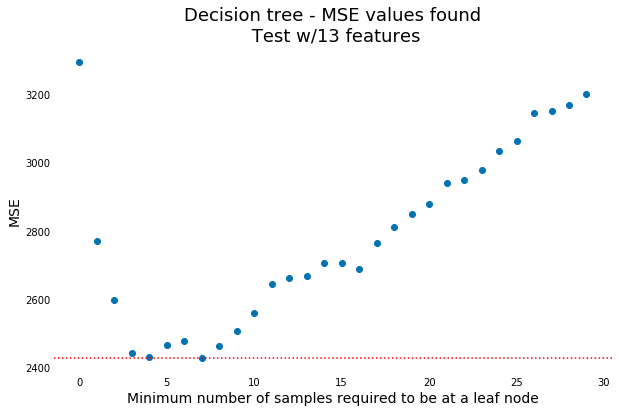

In [20]:
m = min(dt_mse_values)
dt_mse_min = dt_mse_values[dt_mse_values.index(m)]
print('mse_min: ', dt_mse_min)

plt.figure(figsize=(10,6))
plt.scatter(range(30), dt_mse_values)
plt.axhline(dt_mse_min, c='r', ls='dotted')
plt.xlabel('Minimum number of samples required to be at a leaf node', size=14)
plt.ylabel('MSE', size=14)
plt.box(False)
plt.tick_params(axis='both', which='both',length=0)
_ = plt.title('Decision tree - MSE values found\n Test w/13 features', size=18)

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## ML - Random Forest

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=5)
rf.fit(train[features], target)
predictions3 = rf.predict(test[features])
mse3 = mean_squared_error(test['cnt'], predictions3)
mse3

1825.8749459803462

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

In [22]:
rf_mse_values = []
x_points = np.logspace(1, 2.5, 30, dtype=int)
x_points

array([ 10,  11,  12,  14,  16,  18,  20,  23,  25,  29,  32,  37,  41,
        47,  52,  59,  67,  75,  85,  96, 108, 121, 137, 154, 174, 196,
       221, 249, 280, 316])

In [23]:
for m in x_points:
    rf = RandomForestRegressor(n_estimators=m, random_state=0)
    rf.fit(train[features], target)
    rf_predictions = rf.predict(test[features])

    rf_mse = mean_squared_error(test['cnt'], rf_predictions)
    rf_mse_values.append(rf_mse)

In [24]:
m = min(rf_mse_values)
rf_mse_min = rf_mse_values[rf_mse_values.index(m)]
print('mse_min: ', rf_mse_min)

mse_min:  1582.2089728167134


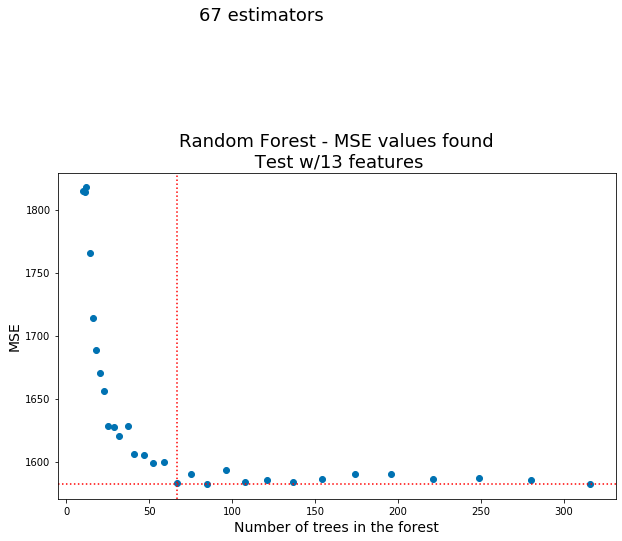

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(x_points, rf_mse_values)
plt.axhline(rf_mse_min, c='r', ls='dotted')
plt.axvline(67, c='r', ls='dotted')
plt.text(x=80,y=1950, s="67 estimators", size=18)
plt.xlabel('Number of trees in the forest', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Random Forest - MSE values found\n Test w/13 features', size=18)